In [1]:
import obspy
from obspy.taup import TauPyModel

from multiprocessing import Pool
from obspy import read,UTCDateTime,Trace,read_inventory,read_events
from obspy.imaging.beachball import beachball,beach
from obspy.clients.fdsn import Client
from obspy.clients.syngine import Client as SyngineClient
from obspy.taup import TauPyModel,plot_ray_paths
import os
import glob
import numpy as np
from collections import defaultdict
import pandas as pd
from scipy import signal
import subprocess
from sklearn import preprocessing
import math

#para plotar as figuras
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition,inset_axes
import matplotlib.cm as cm
from matplotlib.dates import YearLocator, MonthLocator, DayLocator, HourLocator, MinuteLocator, SecondLocator, DateFormatter
from matplotlib.ticker import MultipleLocator, FormatStrFormatter,FixedLocator,StrMethodFormatter
import matplotlib.colors as mcolors
from datetime import datetime,timedelta,date
from tqdm import tqdm

#para gerar os maps
from shapely.geometry.polygon import LinearRing
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
import requests
import csv
import xml.etree.ElementTree as ET

In [17]:
# ========== 
# INPUT DATA
# ========== 

INPUT_DATA = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/FIGURAS/STATISTICS/table_events_selected.csv'
OUTPUT_DATA = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/SYNTHETIC/synthetic_data_glider/'
FOLDER_OUTPUT = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/SYNTHETIC/'

In [18]:
# -----------
# GET FR DATA
# -----------

INPUT_DATA_df = pd.read_csv(INPUT_DATA)

In [19]:
INPUT_DATA_df

Unnamed: 0            filename_mseed name_glider  Phase          ev_ID  \
0            0  GL.G1607..HHH.D.2016.309       G1607      P  201611041620A   
1            1  GL.G170B..HHH.D.2017.105       G170B      P  201704150819A   
2            2  GL.G170F..HHH.D.2017.199       G170F      P  201707180205A   
3            3  GL.G170E..HHH.D.2017.165       G170E      P  201706140729A   
4            4  GL.G180R..HHH.D.2018.302       G180R      P  201810290654A   
5            5  GL.G180L..HHH.D.2018.056       G180L  PKIKP  201802251744A   
6            6  GL.G2014..HHH.D.2020.085       G2014  PKIKP  202003250249A   
7            7  GL.G1608..HHH.D.2017.010       G1608    PKP  201701100613A   
8            8  GL.G190X..HHH.D.2019.192       G190X    PKP  201907111708A   
9            9  GL.G190U..HHH.D.2019.048       G190U    PKP  201902171435A   
10          10  GL.G190X..HHH.D.2019.195       G190X    PKP  201907140910A   
11          11  GL.G180R..HHH.D.2018.286       G180R    PKP  201810131110A   

                        ev_time  ev_lat  ev_long  ev_depth    distance  ...  \
0   2016-11-04T16:20:49.900000Z  -35.06   -70.98      96.2   25.679035  ...   
1   2017-04-15T08:19:48.300000Z  -23.20   -67.92     164.2   21.397327  ...   
2   2017-07-18T02:05:24.600000Z  -16.70   -73.65      66.4   28.407586  ...   
3   2017-06-14T07:29:07.900000Z   14.92   -92.17      72.7   62.215965  ...   
4   2018-10-29T06:54:25.700000Z  -57.55   -66.60      20.7   36.888302  ...   
5   2018-02-25T17:45:08.600000Z   -6.29   142.97      12.0  148.417442  ...   
6   2020-03-25T02:49:32.100000Z   49.11   157.87      52.6  150.590614  ...   
7   2017-01-10T06:13:55.900000Z    4.57   122.78     621.5  155.133807  ...   
8   2019-07-11T17:08:38.800000Z   -4.66   155.19     493.1  146.580679  ...   
9   2019-02-17T14:35:58.100000Z   -3.33   152.13     372.2  148.569270  ...   
10  2019-07-14T09:11:04.600000Z   -0.72   128.13      12.0  152.514159  ...   
11  2018-10-13T11:10:26.900000Z   52.71   153.43     473.4  148.866219  ...   

                    time_glider lat_glider lon_glider  dep_glider  \
0    2016-11-04 16:26:24.000005 -25.949465 -43.016092  -50.167189   
1    2017-04-15 08:25:52.000004 -25.058372 -44.564310 -730.684343   
2    2017-07-18 02:11:13.999999 -25.362501 -44.620017 -844.420010   
3    2017-06-14 07:40:56.000002 -26.011126 -43.866740 -259.584670   
4    2018-10-29 07:04:52.999997 -24.905491 -42.520976 -932.742894   
5           2018-02-25 18:04:53 -24.977420 -42.039230 -526.574787   
6    2020-03-25 03:07:21.999996 -24.625356 -42.926205 -300.467202   
7    2017-01-10 06:33:11.999998 -26.170789 -44.252657 -824.114690   
8    2019-07-11 17:29:31.999998 -24.828114 -41.172499 -362.526307   
9   2019-02-17T13:52:00.000000Z -24.646000 -42.785200 -194.720000   
10   2019-07-14 09:31:33.000002 -24.821791 -41.234815 -345.674589   
11  2018-10-13T09:17:00.000000Z -24.232300 -43.039700 -297.600000   

                                       time_dive_info  \
0   [UTCDateTime(2016, 10, 21, 9, 7) UTCDateTime(2...   
1   [UTCDateTime(2017, 3, 25, 20, 27) UTCDateTime(...   
2   [UTCDateTime(2017, 7, 13, 0, 8) UTCDateTime(20...   
3   [UTCDateTime(2017, 6, 3, 14, 59) UTCDateTime(2...   
4   [UTCDateTime(2018, 10, 4, 5, 13) UTCDateTime(2...   
5   [UTCDateTime(2018, 2, 23, 12, 24) UTCDateTime(...   
6   [UTCDateTime(2020, 3, 25, 2, 7) UTCDateTime(20...   
7   [UTCDateTime(2016, 11, 21, 4, 14) UTCDateTime(...   
8   [UTCDateTime(2019, 6, 29, 15, 26) UTCDateTime(...   
9   [UTCDateTime(2019, 2, 10, 14, 9) UTCDateTime(2...   
10  [UTCDateTime(2019, 6, 29, 15, 26) UTCDateTime(...   
11  [UTCDateTime(2018, 10, 4, 5, 13) UTCDateTime(2...   

                                        lat_dive_info  \
0   [-24.6694 -24.689 -24.706 -24.7378 -24.7688 -2...   
1   [-24.54 -24.6419 -24.6399 -24.6386 -24.6993 -2...   
2   [-25.6281 -25.6122 -25.6036 -25.5429 -25.5314 ...   
3   [-25.5097 -25.5265 -25.5257 -25.5253 -25.5306 ...   
4   [-24.904 -24.9463 -24.965 -24.96

In [20]:
# --------------------------
# Looking for synthetic data
# --------------------------

def read_down_save_syn(itera):
    row = itera[1]
   
    # Choosing a model
    model_time = TauPyModel(model="prem")
    
    # Calculating distance, azimuth and backazimuth
    dist,az,baz = obspy.geodetics.gps2dist_azimuth(row['ev_lat'],row['ev_long'],row['lat_glider'],row['lon_glider'])
    gcarc = obspy.geodetics.kilometer2degrees(dist/1000)
    
    # Calculating arrival time
    arrivals = model_time.get_travel_times(source_depth_in_km=row['ev_depth'], distance_in_degree=gcarc, phase_list=[row['Phase']])
    arr = arrivals[0]
    event_time_o = arr.time
    event_time = UTCDateTime(row['ev_time']) + event_time_o

    event_DD = '{:02}'.format(event_time.day)
    event_MM = '{:02}'.format(event_time.month)
    event_YYYY = event_time.year
    event_hh = '{:02}'.format(event_time.hour)
    event_mm = '{:02}'.format(event_time.minute)
    event_sta = row['name_glider']
    event_ray = arr.ray_param/6371
    sta_lat = row['lat_glider']
    sta_long = row['lon_glider']

    eventid = 'GCMT:C'+row['ev_ID']
    
    # --------------------------
    # DOWNLOADING SYNTHETIC DATA
    # --------------------------
    
    c_s = SyngineClient()
    model = "iasp91_2s"

    for i in range(10,180,10):

        st_synth = obspy.Stream(c_s.get_waveforms(model=model,receiverlatitude=sta_lat,receiverlongitude=sta_long,networkcode='GL',stationcode=event_sta,eventid=eventid,dt="0.1",starttime=event_time-30, endtime=event_time+260,components='Z',units='acceleration',format='saczip'))

        for r,t in enumerate(st_synth):
            evdp = row['ev_depth']            
            
            j = obspy.UTCDateTime(row['ev_time'])
            
            t.stats.sac.user0 = event_ray
            t.stats.sac.user8 = 1

            folder_loc_string = OUTPUT_DATA+t.stats.station+'/'+str(j.year)+'/'+str("{0:0=3d}".format(j.julday))+'/'+str(j.year)+'.'+str(j.julday)+'.'+str(j.hour)+'.'+str(j.minute)+'.'+str(j.second)+'.'+str(j.microsecond)
            os.makedirs(folder_loc_string,exist_ok=True)
            t.write(folder_loc_string+'/SYN.GL.'+event_sta+'.'+str(j.year)+'.'+str(j.hour)+'.'+str(j.minute)+'.'+str(j.second)+'.'+str(j.microsecond)+'.'+t.stats.channel[-1],format='SAC')
# -------------------------------------------------------------------------------------------

In [21]:
# ===================
# Download event data
# ===================

print('Download event data for each station via syngine')
print('\n')

with Pool(processes=12) as p:
    max_ = len(INPUT_DATA_df)
    with tqdm(total=max_,desc='GCMT synthetic event download') as pbar:
        for i, _ in enumerate(p.imap_unordered(read_down_save_syn,INPUT_DATA_df.iterrows())):
            pbar.update()

print('Finished!')

Download event data for each station via syngine




GCMT synthetic event download: 100%|████████████| 12/12 [00:15<00:00,  1.25s/it]

Finished!


In [22]:
def deslocar_coordenadas_em_graus(latitude, longitude, delta_angular, angulo):
    # Converter latitude e longitude de graus para radianos
    lat_rad = math.radians(latitude)
    lon_rad = math.radians(longitude)
    
    # Converter ângulo de graus para radianos
    angulo_rad = math.radians(angulo)
    
    # Calcular o deslocamento em graus na latitude e longitude
    delta_lat = delta_angular * math.cos(angulo_rad)
    delta_lon = delta_angular * math.sin(angulo_rad)
    
    # Calcular a nova latitude e longitude considerando a distorção de longitude com a latitude
    nova_latitude = latitude + delta_lat
    nova_longitude = longitude + delta_lon / math.cos(lat_rad)
    
    return nova_latitude, nova_longitude

In [36]:
# -----------------------------------
# Looking for synthetic data + delta
# ----------------------------------

def read_down_save_syn_delta(itera):

    try:
        row = itera[0]
        delta = itera[1]
    
        # Choosing a model
        model_time = TauPyModel(model="prem")
        _,az_angle,__ = obspy.geodetics.gps2dist_azimuth(row['ev_lat'],row['ev_long'],row['lat_glider'],row['lon_glider'])

        # Calculating distance, azimuth and backazimuth      
        #new_lat, new_lon = deslocar_coordenadas_em_graus(row['ev_lat'],row['ev_long'],delta, az_angle)
        new_lat, new_lon = deslocar_coordenadas_em_graus(row['ev_lat'],row['ev_long'],delta, 90)
        dist,az,baz = obspy.geodetics.gps2dist_azimuth(row['ev_lat'],row['ev_long'],new_lat,new_lon)
        gcarc = obspy.geodetics.kilometer2degrees(dist/1000)
    
        # Calculating arrival time
        arrivals = model_time.get_travel_times(source_depth_in_km=row['ev_depth'], distance_in_degree=gcarc, phase_list=['P','PKP','PKIKP'])
        arr = arrivals[0]
        event_time_o = arr.time
        event_time = UTCDateTime(row['ev_time']) + event_time_o

        # ----------------------------------------
        event_DD = '{:02}'.format(event_time.day)
        event_MM = '{:02}'.format(event_time.month)
        event_YYYY = event_time.year
        event_hh = '{:02}'.format(event_time.hour)
        event_mm = '{:02}'.format(event_time.minute)
        event_sta = row['name_glider']
        event_ray = arr.ray_param/6371

        # ----------------------------------------
        sta_lat = new_lat
        sta_long = new_lon

        eventid = 'GCMT:C'+row['ev_ID']

        # --------------------------
        # DOWNLOADING SYNTHETIC DATA
        # --------------------------

        c_s = SyngineClient()
        model = "iasp91_2s"

        st_synth_delta = obspy.Stream(c_s.get_waveforms(model=model,receiverlatitude=new_lat,receiverlongitude=new_lon,networkcode='GL',stationcode=event_sta,eventid=eventid,dt="0.1",starttime=event_time-30, endtime=event_time+260,components='Z',units='acceleration',format='saczip'))

        for r,t in enumerate(st_synth_delta):
                evdp = row['ev_depth']            

                j = UTCDateTime(row['ev_time'])

                t.stats.sac.user0 = event_ray
                t.stats.sac.gcarc = gcarc
                t.stats.sac.user8 = 0

                folder_loc_string = OUTPUT_DATA+t.stats.station+'/'+str(j.year)+'/'+str("{0:0=3d}".format(j.julday))+'/'+str(j.year)+'.'+str(j.julday)+'.'+str(j.hour)+'.'+str(j.minute)+'.'+str(j.second)+'.'+str(j.microsecond)
                os.makedirs(folder_loc_string,exist_ok=True)
                t.write(folder_loc_string+'/SYN.GL.'+event_sta+'.'+'d'+str(delta)+'.'+str(j.year)+'.'+str(j.hour)+'.'+str(j.minute)+'.'+str(j.second)+'.'+str(j.microsecond)+'.'+t.stats.channel[-1],format='SAC')
    # -------------------------------------------------------------------------------------------
    except:
        pass

In [37]:
input_data_delta_row = []
for row in INPUT_DATA_df.iterrows():
    for delta_loc in range(10,180+2,2):
        input_data_delta_row.append([row[1],delta_loc])

In [38]:
# ===================
# Download event data
# ===================

print('Download event data for each station via syngine')
print('\n')

with Pool(processes=12) as p:
    max_ = len(input_data_delta_row)
    with tqdm(total=max_,desc='GCMT synthetic event download') as pbar:
        for i, _ in enumerate(p.imap_unordered(read_down_save_syn_delta,input_data_delta_row)):
            pbar.update()

print('Finished!')

Download event data for each station via syngine




GCMT synthetic event download: 100%|████████| 1032/1032 [01:49<00:00,  9.45it/s]

Finished!


In [39]:
directories = glob.glob('/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/SYNTHETIC/synthetic_data_glider/*/*/*/*')

In [40]:
# Função para verificar se um índice é próximo de múltiplos de 4
def is_proximo_de_multiplo_de_4(i):
    return i % 10 == 0 or i % 10 == 1 or i % 10 == 9

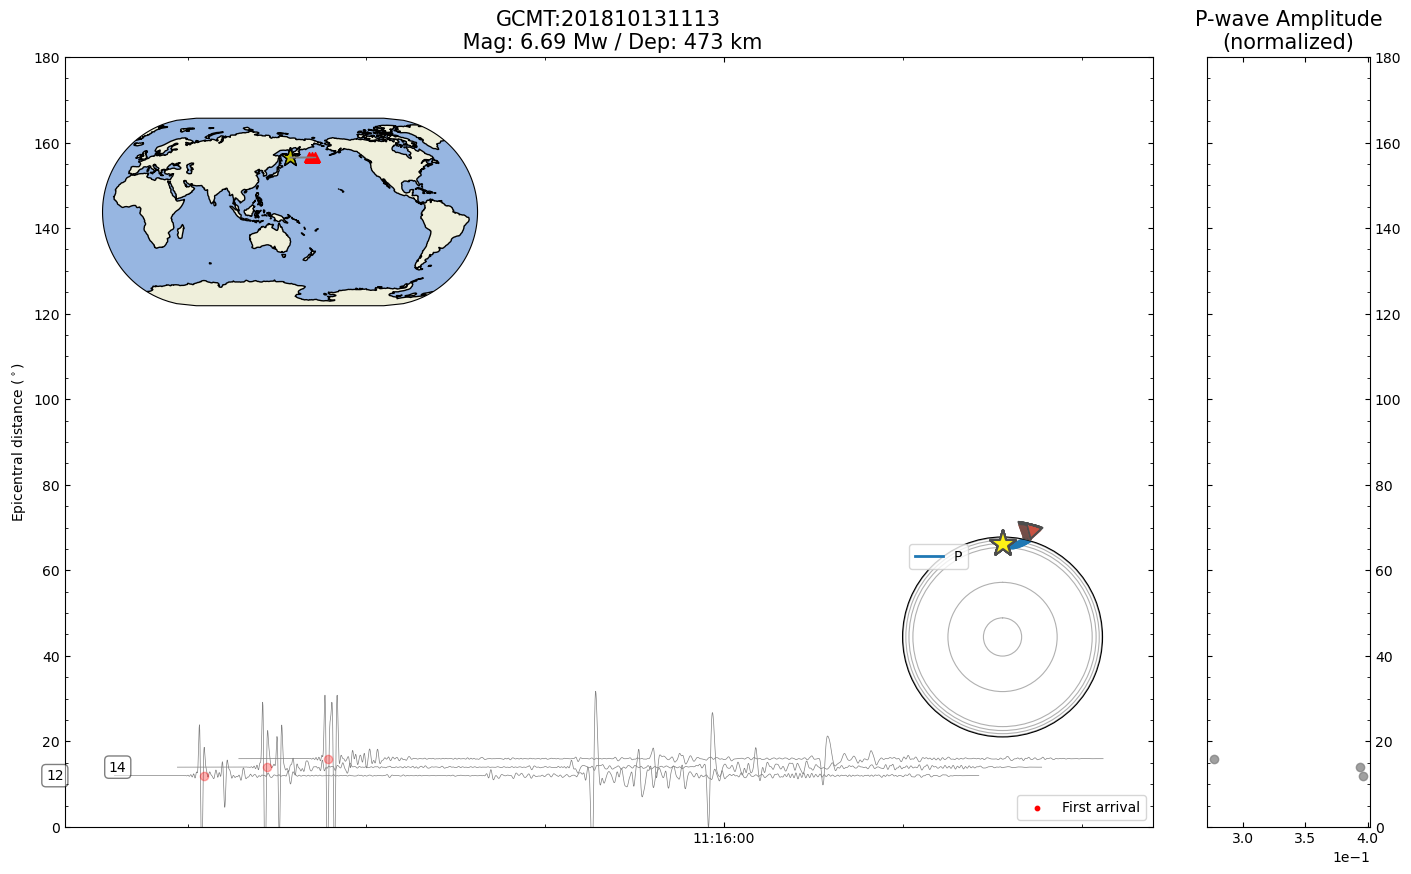

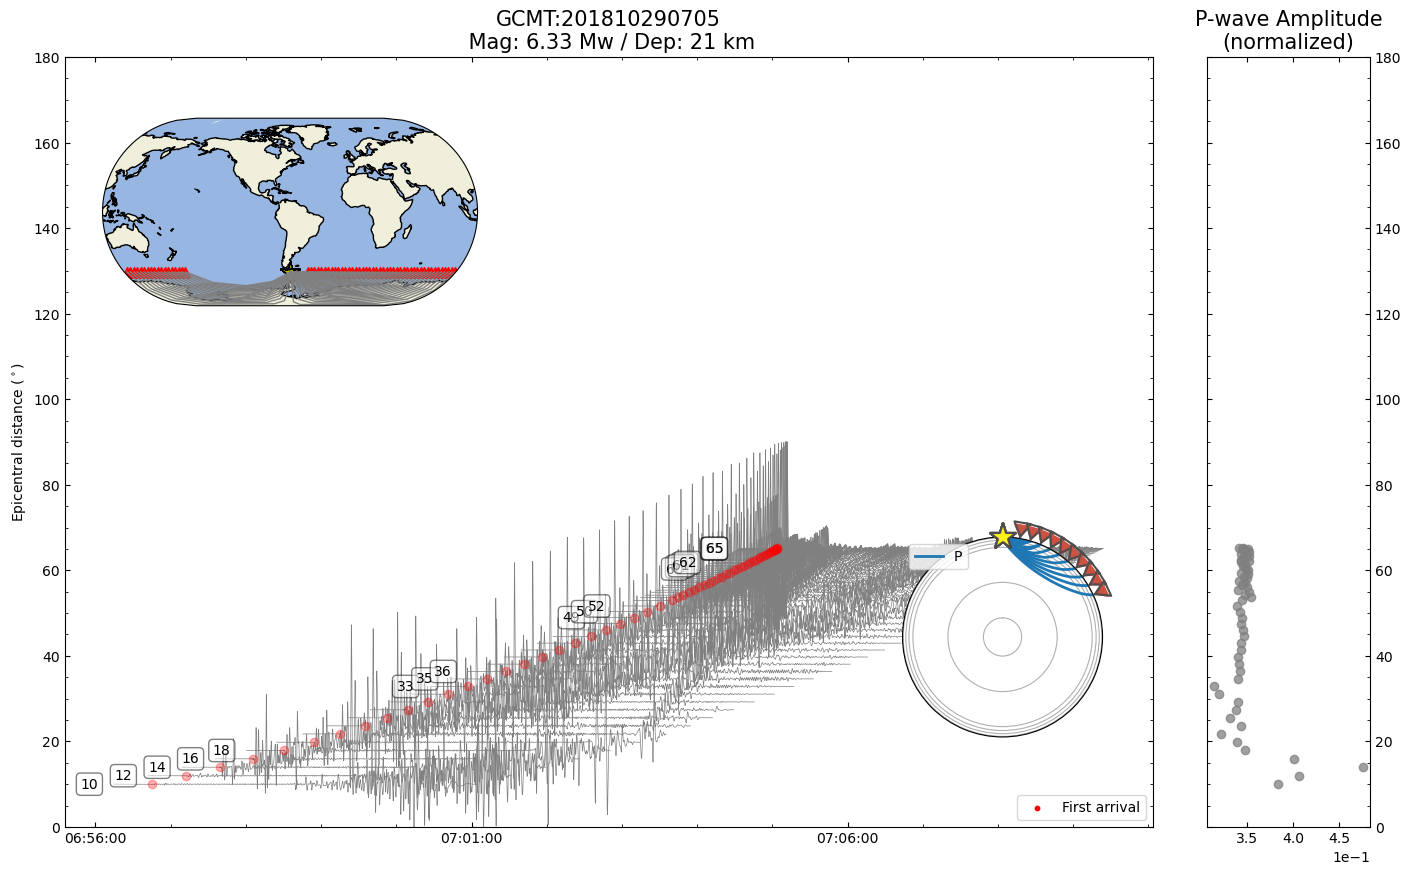

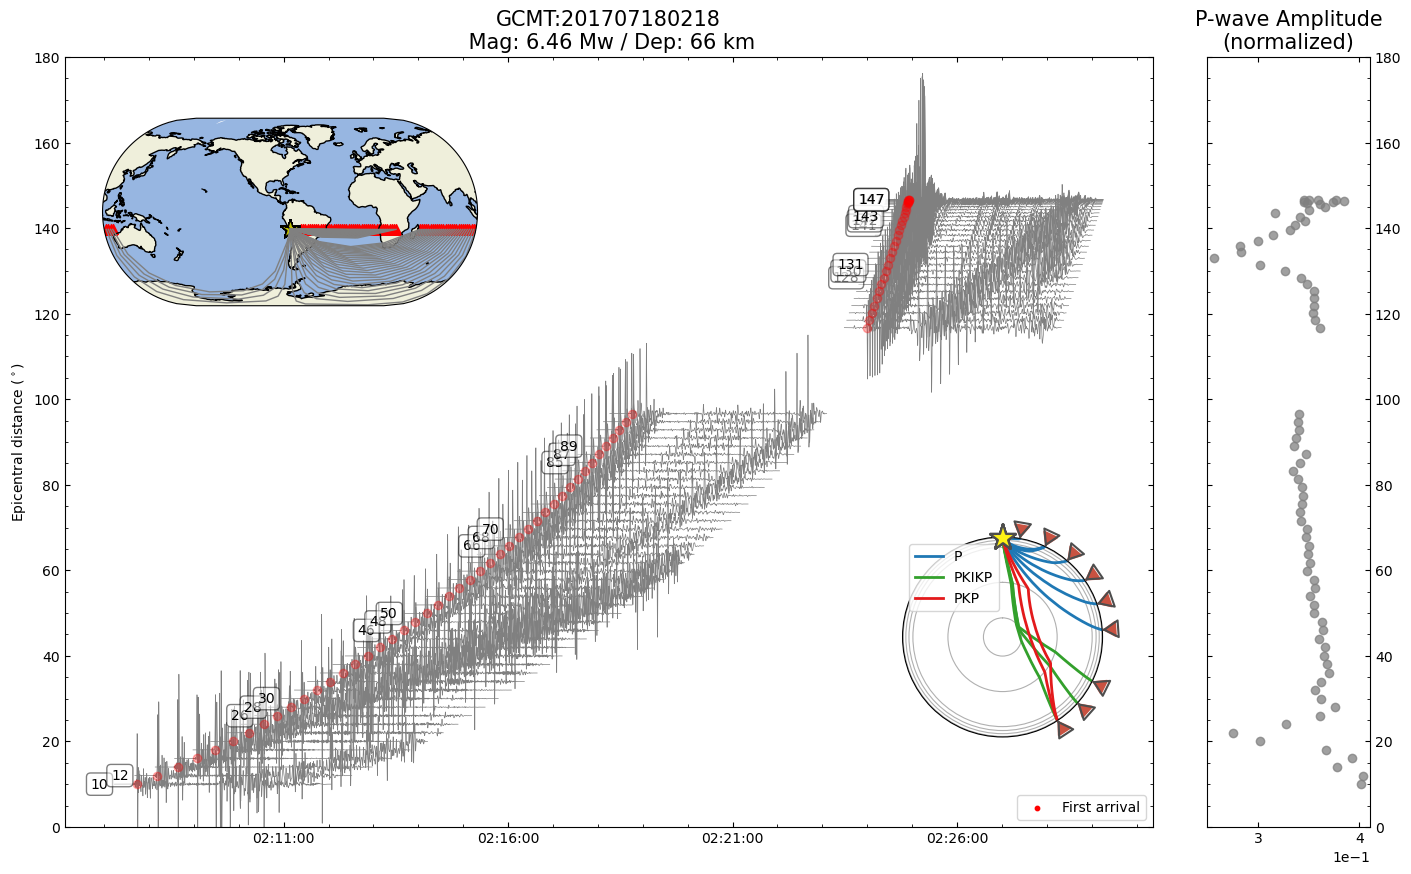

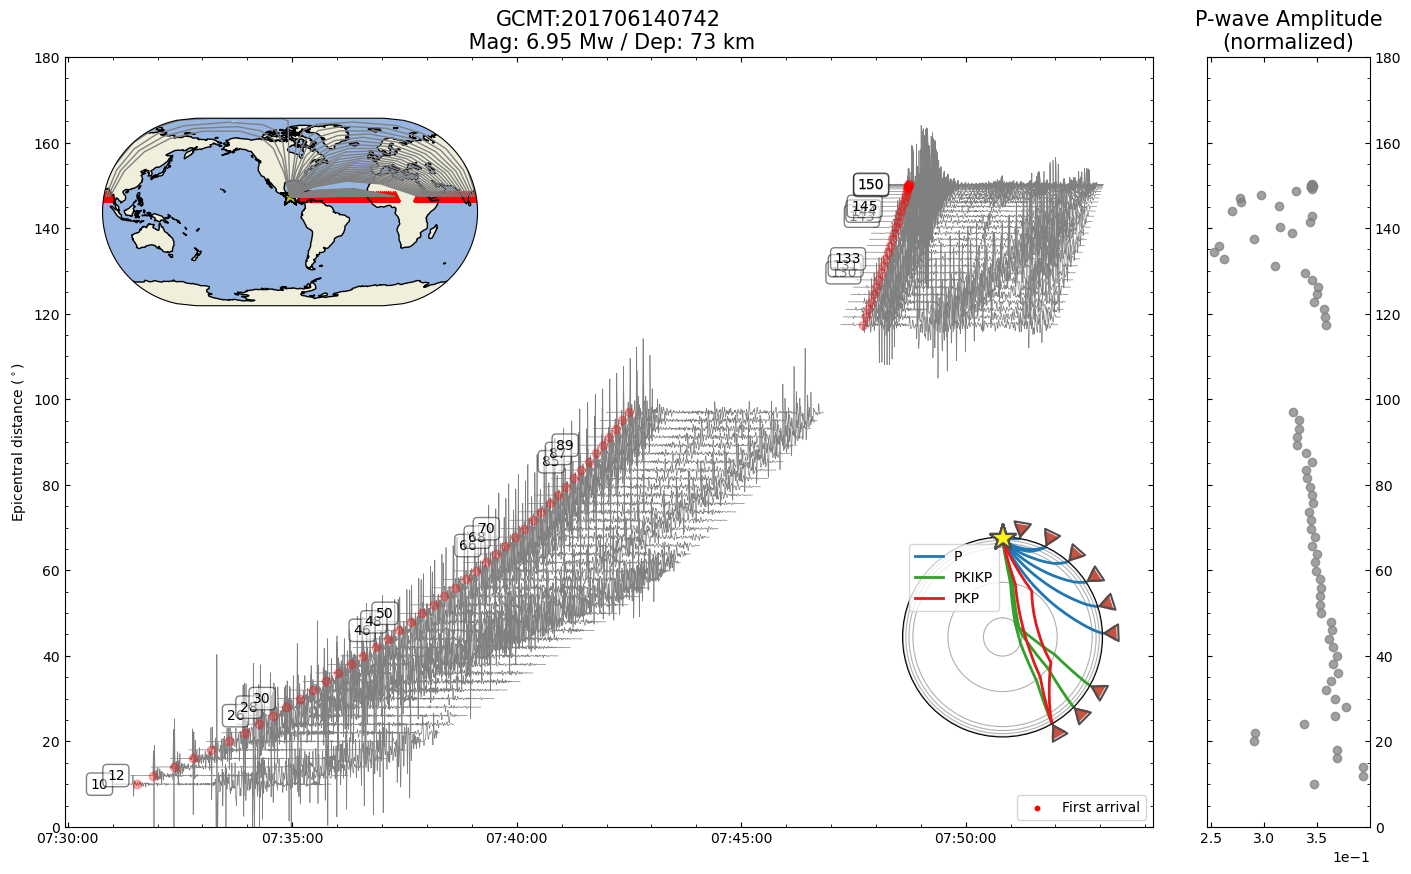

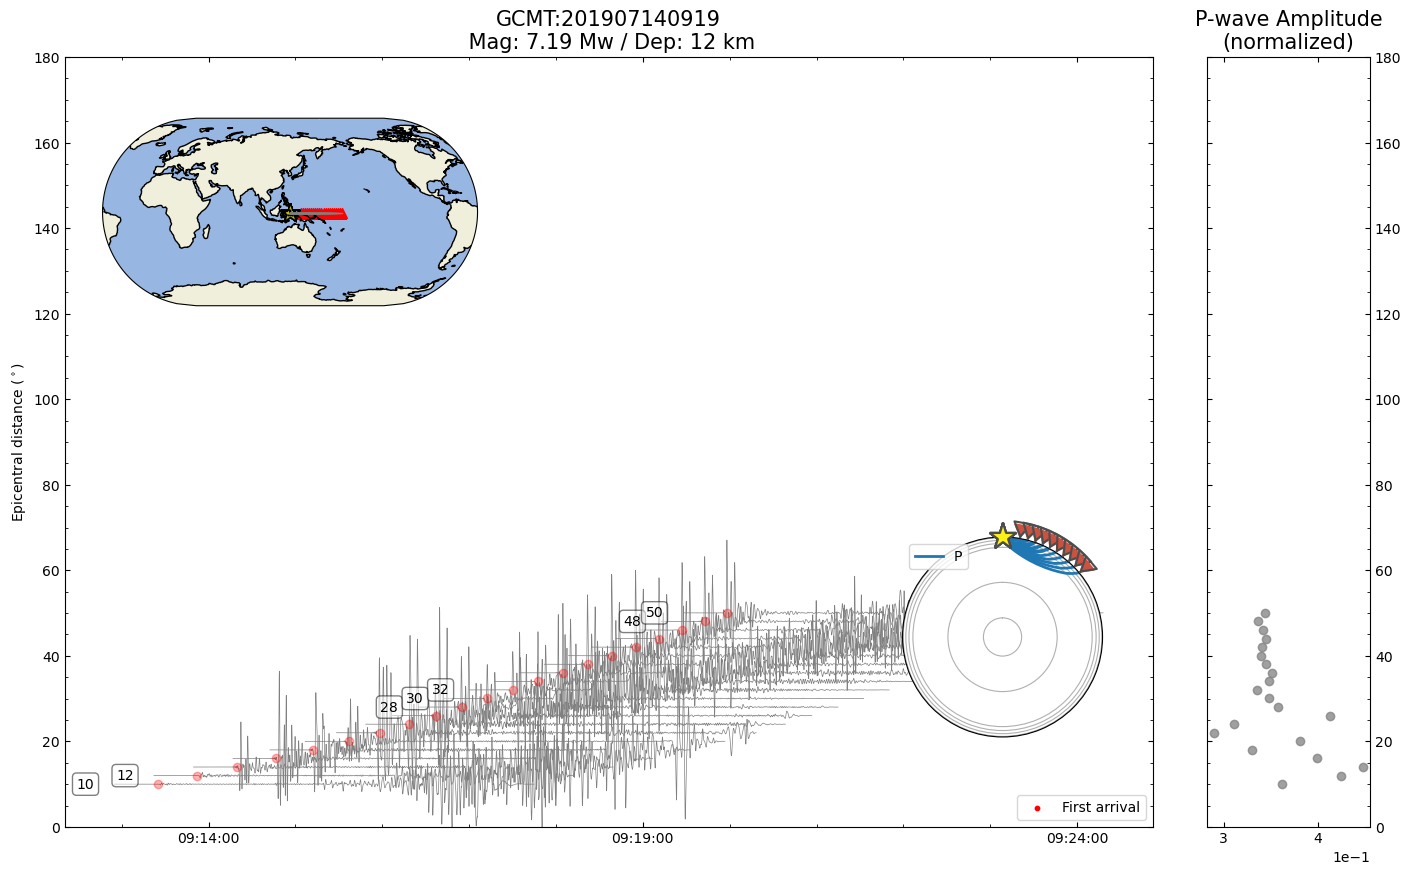

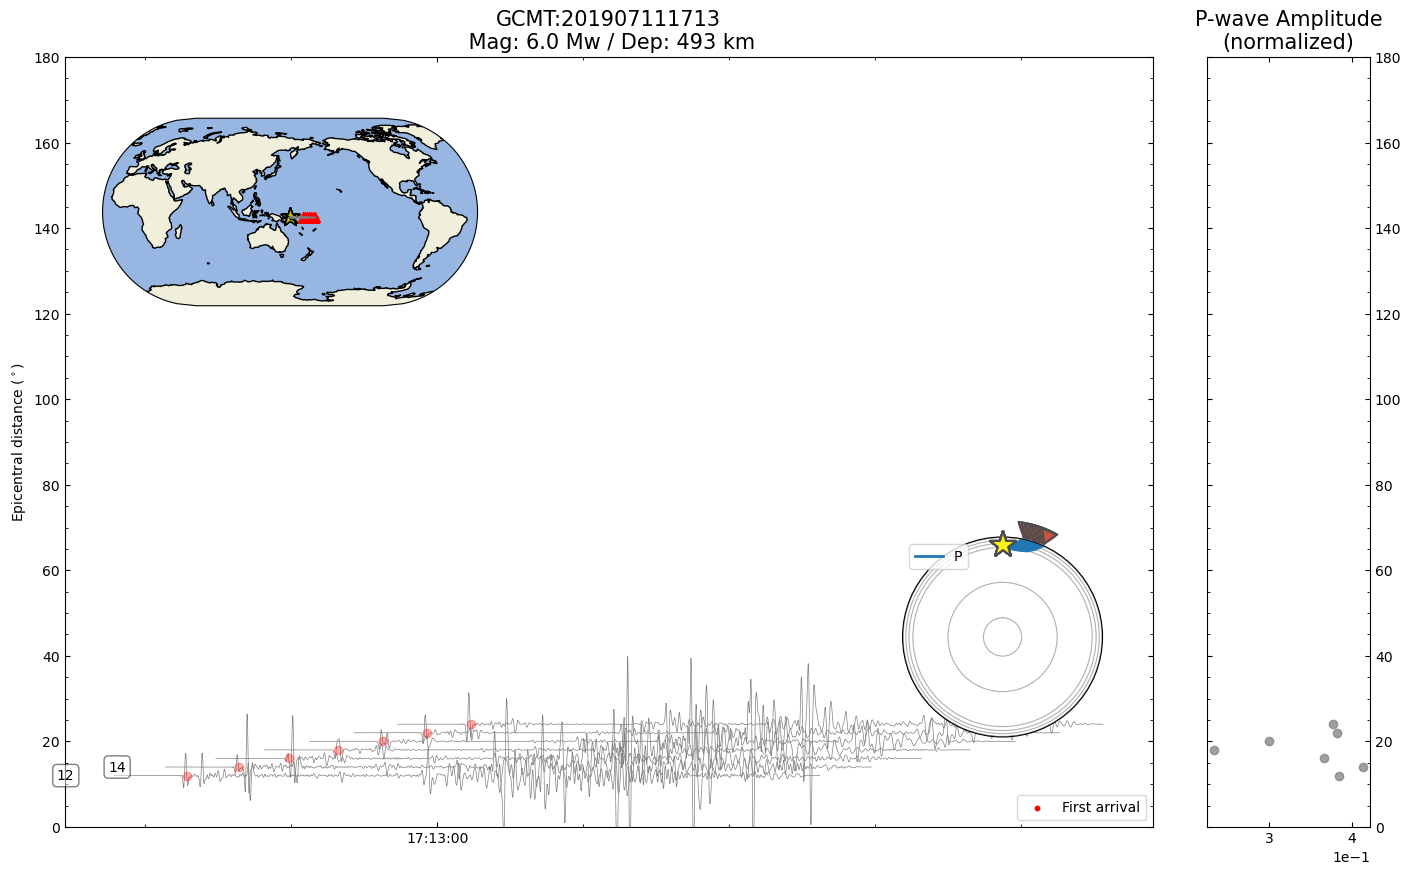

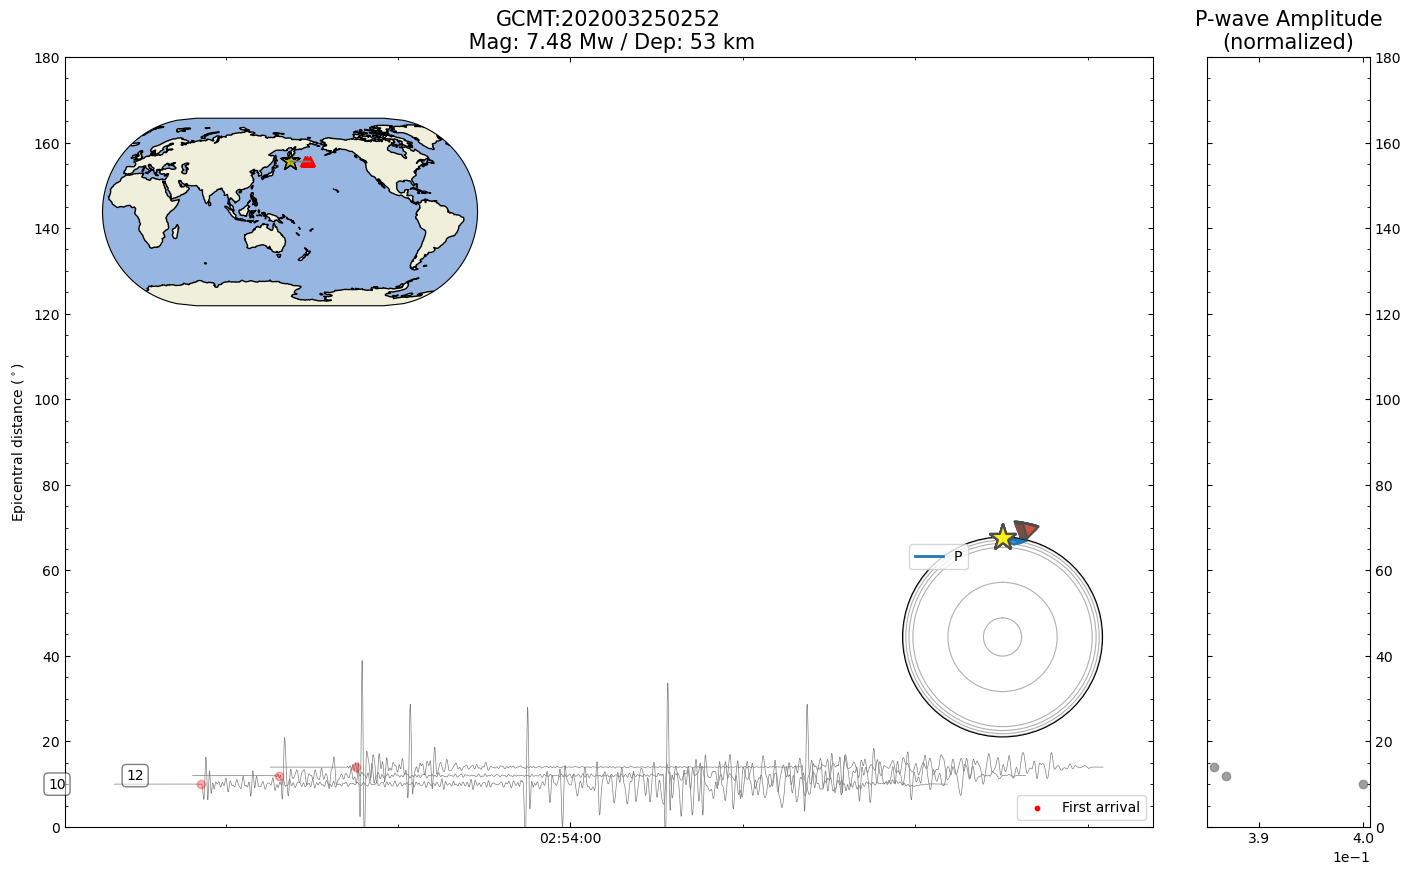

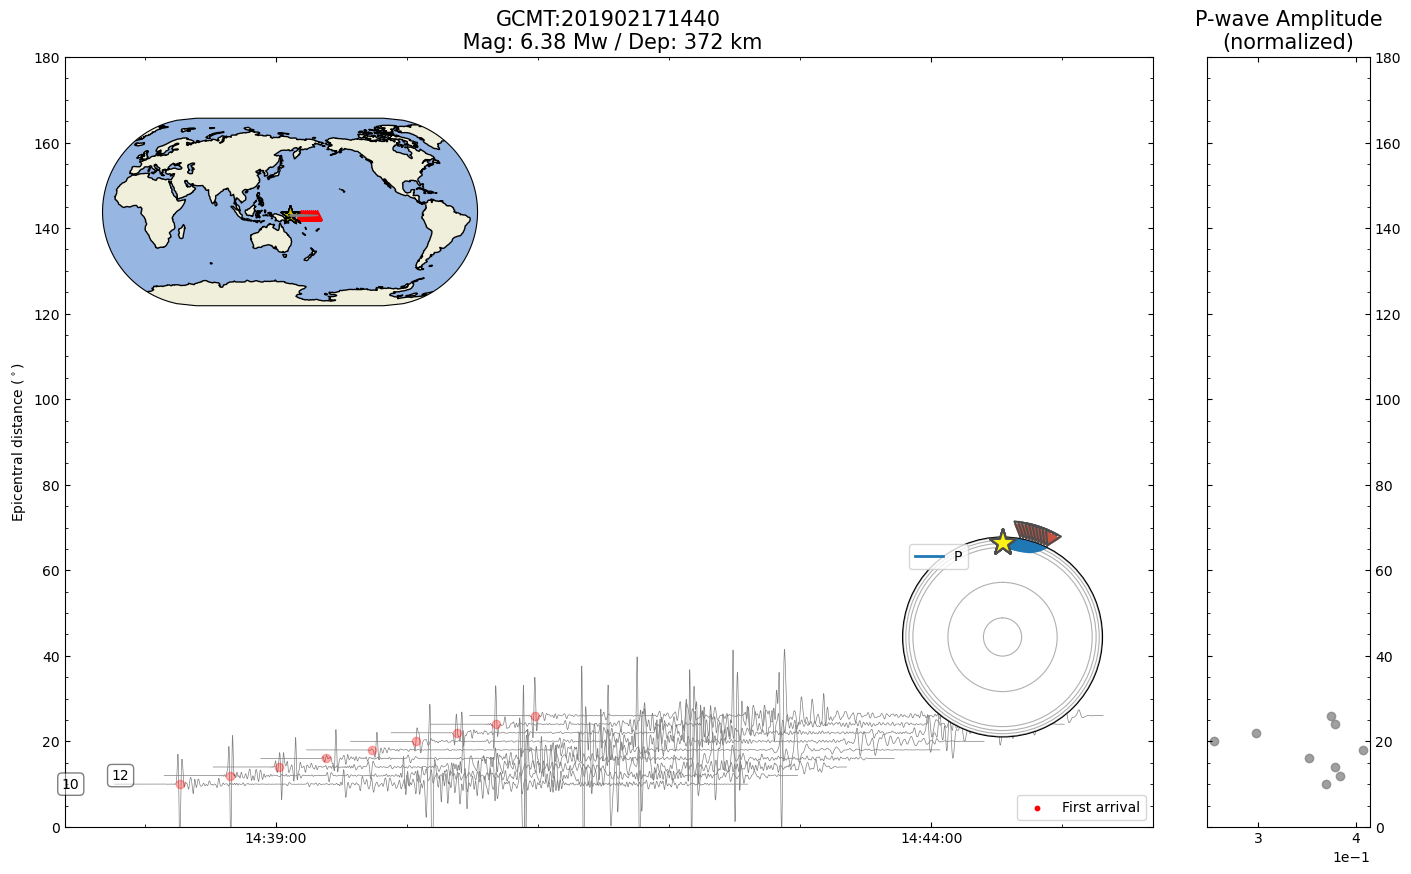

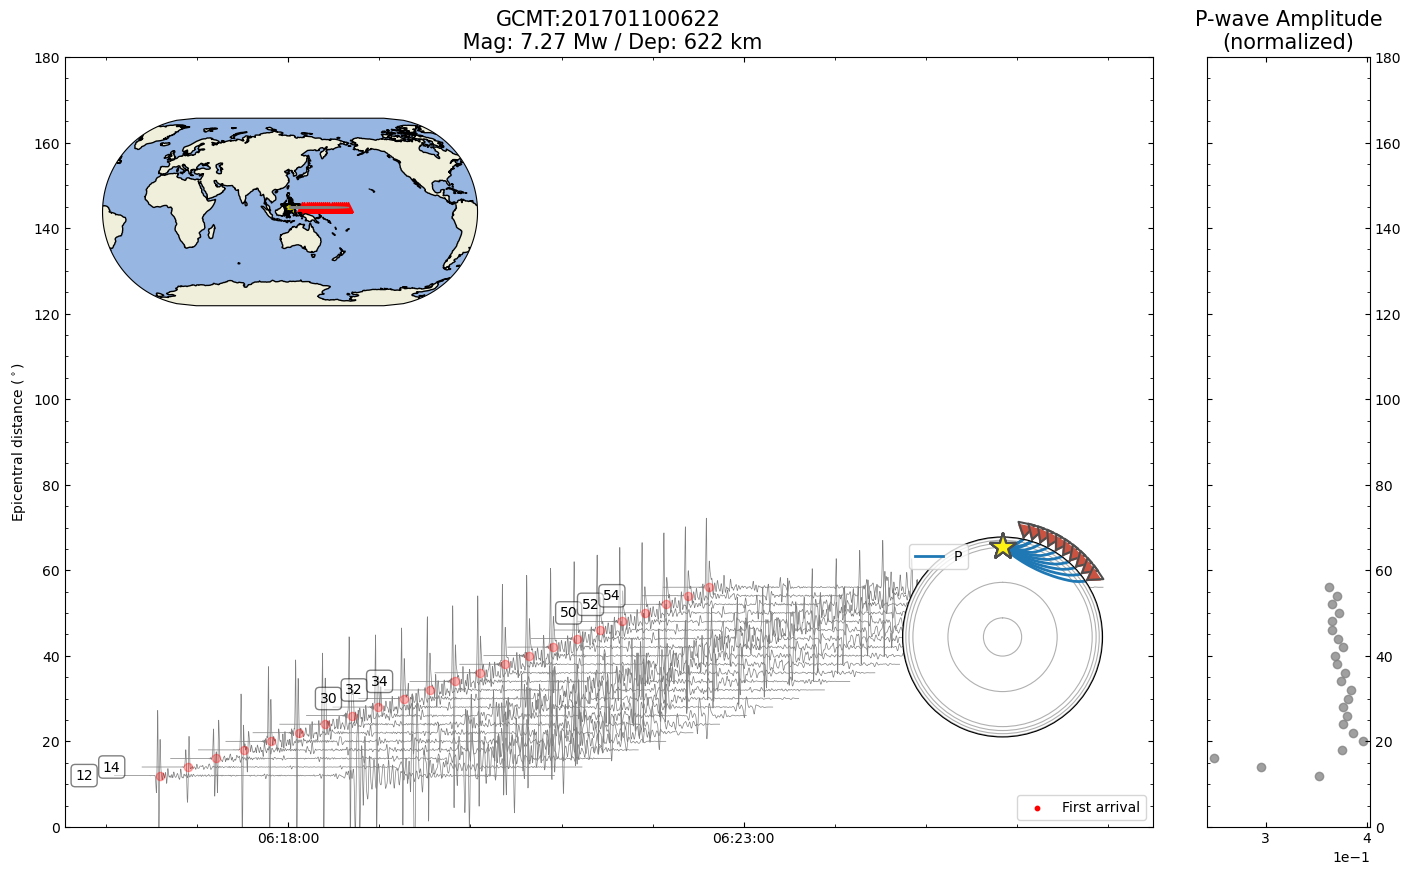

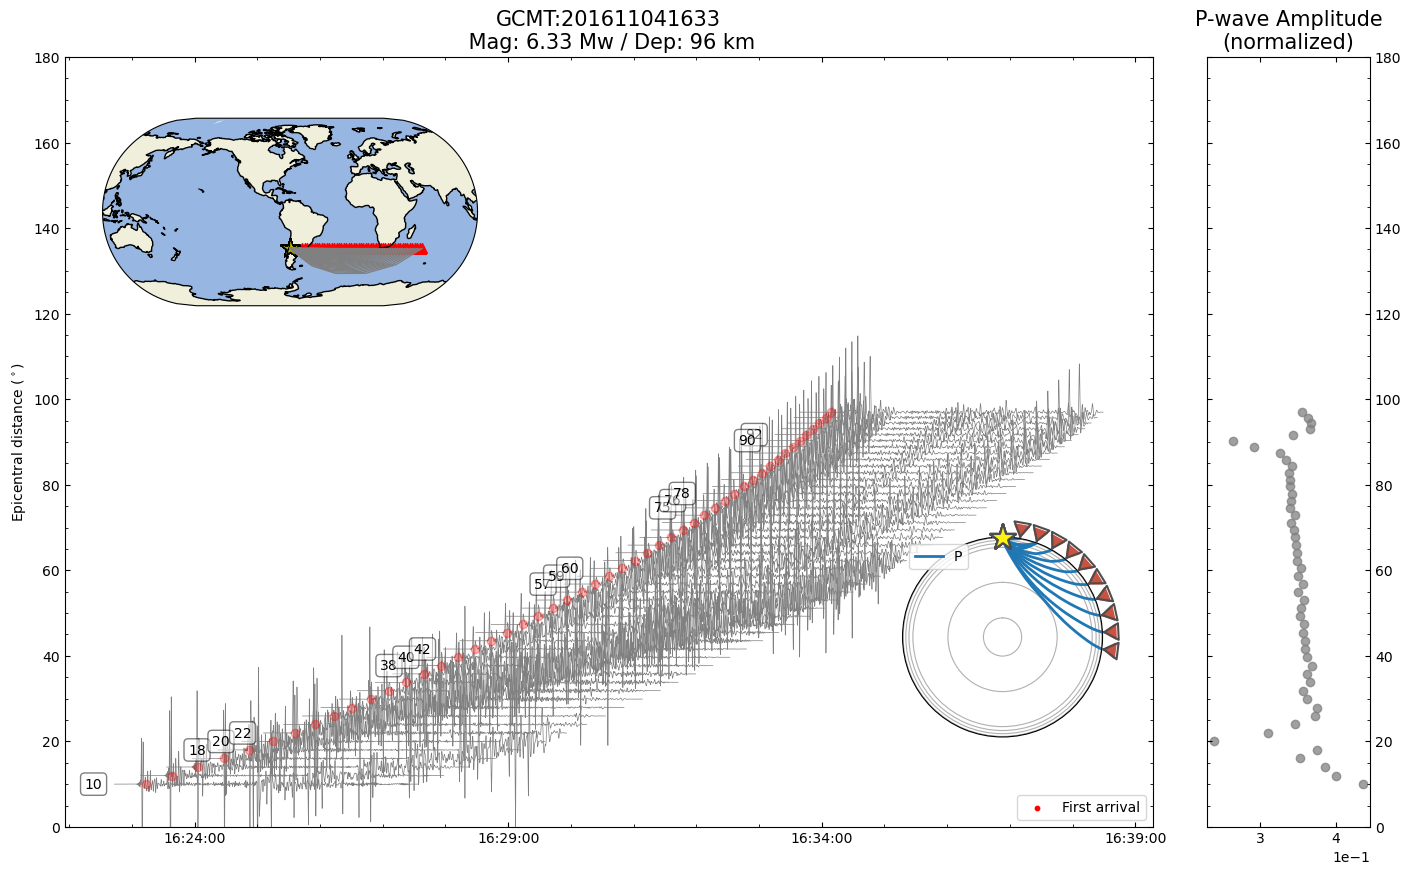

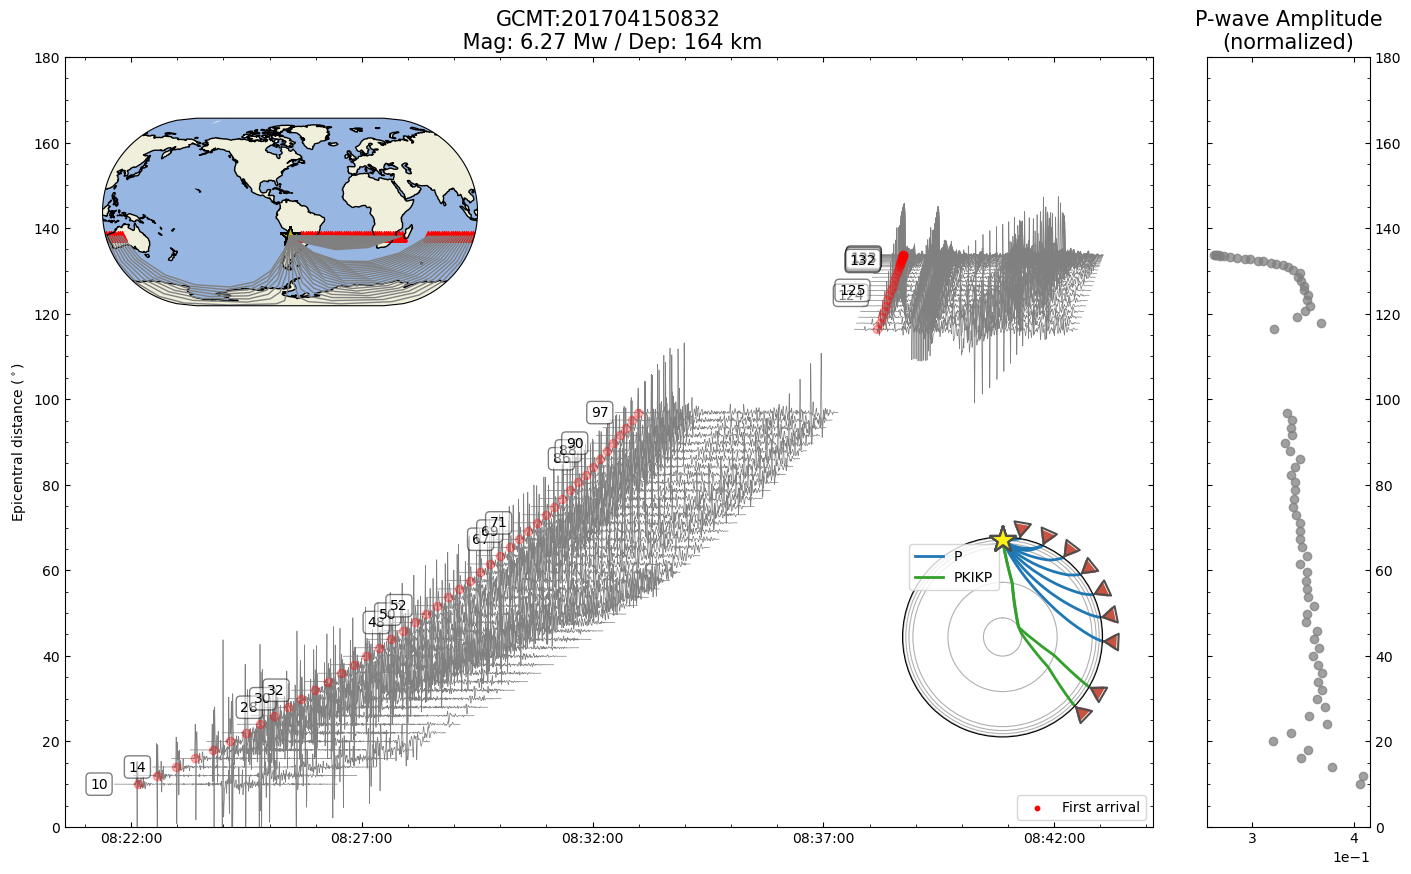

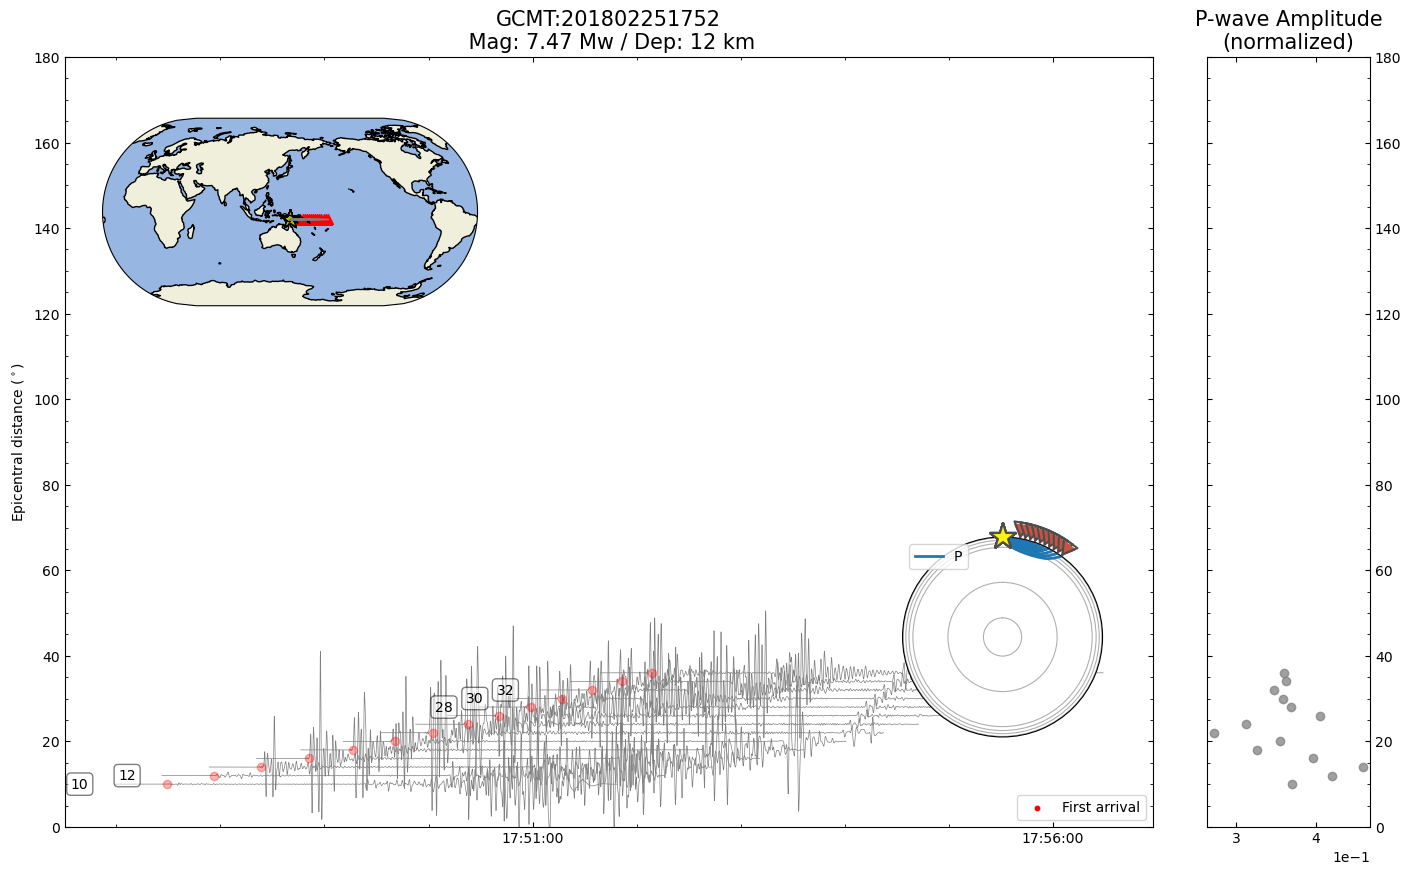

In [42]:
for folder in directories:
#########################################################################################################################################################
    #Figure REGIONAL

    # Matching the events files with the catalog:
    model = TauPyModel(model="ak135")

    data_event = obspy.read(folder+'/*')

    # set up the plot and create a GeoAxes:
    fig = plt.figure(figsize=(15,10))

    ax = fig.add_gridspec(right=0.85).subplots()
    # ----------------------------------------------------------------------------------------------------------
    # Adding global location map
    # ----------------------------------------------------------------------------------------------------------

    # Adding Geoaxes
    ax_map = plt.axes([0.15, 0.6, 0.25, 0.25], projection=ccrs.EckertIII(central_longitude=round(data_event[0].stats.sac.evlo)))
    ax_map.set_global()

    # Adding background map 
    ax_map.add_feature(cfeature.LAND)
    ax_map.add_feature(cfeature.OCEAN)
    ax_map.add_feature(cfeature.COASTLINE)
    
    # ----------------------------------------------------------------------------------------------------------
    # ray paths
    # ----------------------------------------------------------------------------------------------------------
    ax_raypath = fig.add_axes([0.65, 0.2, 0.2,  0.2], projection='polar')
    # ----------------------------------------------------------------------------------------------------------
    ax_histy = ax.inset_axes([1.05, 0, 0.15, 1], sharey=ax)
    #-----------------------------------------------------------------------------------------------------------


    amp_P_lst = []
    gcarc_lst = []
    for id,st_p in enumerate(data_event):
        
        stla = st_p.stats.sac.stla
        stlo = st_p.stats.sac.stlo
        stel = st_p.stats.sac.stel
        stdp = st_p.stats.sac.stdp
        evla = st_p.stats.sac.evla
        evlo = st_p.stats.sac.evlo
        evdp = st_p.stats.sac.evdp/1000
        evmag = st_p.stats.sac.mag

        st_p.filter('lowpass',freq=3,corners=4,zerophase=True)
        st_p.taper(max_percentage=0.1)
        st_p.detrend('linear')
        st_p.detrend('demean')

        #Event time at each station
        #Calculating distance, azimuth and backazimuth

        dist,az,baz = obspy.geodetics.gps2dist_azimuth(evla,evlo,stla,stlo)
        gcarc = obspy.geodetics.kilometer2degrees(dist/1000)
        event_time_trace = st_p.stats.starttime
        gcarc_lst.append(gcarc) 

        # Retrieving the P-wave amplitude between -1 and +1 seconds
        amp_P_index = np.where(st_p.times('utcdatetime') == event_time_trace+30)[0][0]
        amp_P = abs(max(preprocessing.normalize([st_p.data[amp_P_index-30:amp_P_index+30]])[0], key=abs))
        amp_P_lst.append(amp_P)

        # ----------------------------------------------------------------
            
        times = [mdates.date2num(event_time_trace+(i)) for i in st_p.times()]
        ax.plot(times,gcarc+preprocessing.normalize([st_p.data])[0]*100,c='grey',ls='-',lw=0.5,zorder=-10)
        ax.scatter(x=mdates.date2num(event_time_trace+30),y=gcarc,c='r',alpha=0.3,zorder=1)
        
        if is_proximo_de_multiplo_de_4(id):
            ax.text(x=mdates.date2num(event_time_trace-20),y=gcarc,s=str(round(gcarc)),ha="center",va="center",bbox=dict(boxstyle="round",ec='k',fc='w',alpha=0.5))

        # -----------------------------------------------------------------------------------------
            
        ax_map.plot([stlo, evlo], [stla, evla], c='gray',ls='-',lw=1, transform=ccrs.Geodetic())  
        ax_map.scatter(evlo,evla,color="y",marker='*',s=200,ec='k',transform=ccrs.PlateCarree())
        ax_map.scatter(stlo,stla,color="r",marker='^',s=50,transform=ccrs.PlateCarree())
        
        # -----------------------------------------------------------------------------------------
        
        ax_histy.scatter(amp_P,gcarc,c='grey',alpha=0.75)
        
        # ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

        if st_p.stats.sac.user8 == 1:
            ax.plot(times,gcarc+preprocessing.normalize([st_p.data])[0]*100,c='black',ls='-',lw=1,zorder=2,label='Glider (loc)')
            ax_map.scatter(stlo,stla,color="b",marker='^',s=50,transform=ccrs.PlateCarree())
            ax_histy.scatter(amp_P,gcarc,c='k',alpha=0.75)

    # Configurar o eixo x para usar notação científica
    ax_histy.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax_histy.set_title('P-wave Amplitude'+'\n'+'(normalized)',fontsize=15)
    ax_histy.tick_params(axis='both', which='both', direction='in',bottom=True, top=True, left=True, right=True,
                       labelbottom=True, labeltop=False, labelleft=False, labelright=True)

    ax.set_title('GCMT:'+(event_time_trace+30).strftime('%Y%m%d%H%M')+'\n Mag: '+str(round(evmag,2))+' Mw'+' / Dep: '+str(round(evdp))+' km',fontsize=15)
    ax.set_ylabel('Epicentral distance ($^\circ$)')

    # Adicionar um ponto fora do loop para a legenda
    ax.scatter([], [], color='r', s=10,label='First arrival')
    ax.legend(loc='lower right')
    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
    ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    ax.set_ylim(0,180)
    ax.yaxis.set_major_locator(MultipleLocator(20))
    ax.yaxis.set_minor_locator(MultipleLocator(5))
    ax.tick_params(axis='both', which='both', direction='in',bottom=True, top=True, left=True, right=True,
                       labelbottom=True, labeltop=False, labelleft=True, labelright=False)
    # --------------------------------------------------------------------------------------------------------
    plot_ray_paths(source_depth=evdp, min_degrees=min(gcarc_lst), max_degrees=max(gcarc_lst), npoints=10, plot_type='spherical', phase_list=['P','PKP','PKIKP'], model='ak135', legend=True,ax=ax_raypath)
    # ---------------------------------------------------------------------------------------------------------------------------------------    

    # Saving figure
    os.makedirs(FOLDER_OUTPUT+'SYNTHETIC_EVENTS/',exist_ok=True)
    fig.savefig(FOLDER_OUTPUT+'SYNTHETIC_EVENTS/'+'event_'+folder.split('/')[-1]+'.png',pad_inches=1,dpi=200)
    plt.close()

    #plt.show()